In [2]:
import os
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience
from dotenv import load_dotenv, find_dotenv

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [43]:
# Use python-dotenv to securely load credentials to AuraDS
dotenv_loc = find_dotenv()
load_dotenv(dotenv_loc)

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USR = os.getenv("NEO4J_USR")
NEO4J_PWD = os.getenv("NEO4J_PWD")

gds = GraphDataScience(NEO4J_URI, auth=(NEO4J_USR, NEO4J_PWD))

In [44]:
# Call a GDS method directly
print(gds.version())

2.1.5


In [5]:
def delete_orphan_nodes():
    query = """
    match (orphans) 
    where size((orphans)--())=0 
    detach delete orphans;
    """
    return gds.run_cypher(query)


# Delete all orphan nodes
delete_orphan_nodes()

""


<b>Check-out the graph's schema via: (see below for visualization)</b>

- `CALL db.schema.visualization();`
    - The graph is a modified/updated version of [Project Rephetio](https://het.io/about/)
        - Hetionet has been refined/distilled along with being integrated with the [Unified Medical Language System (UMLS)](https://www.nlm.nih.gov/research/umls/index.html) via associating all nodes in the graph with a UMLS concept_unique_identifier (i.e. UMLS CUI or `cui` node property).

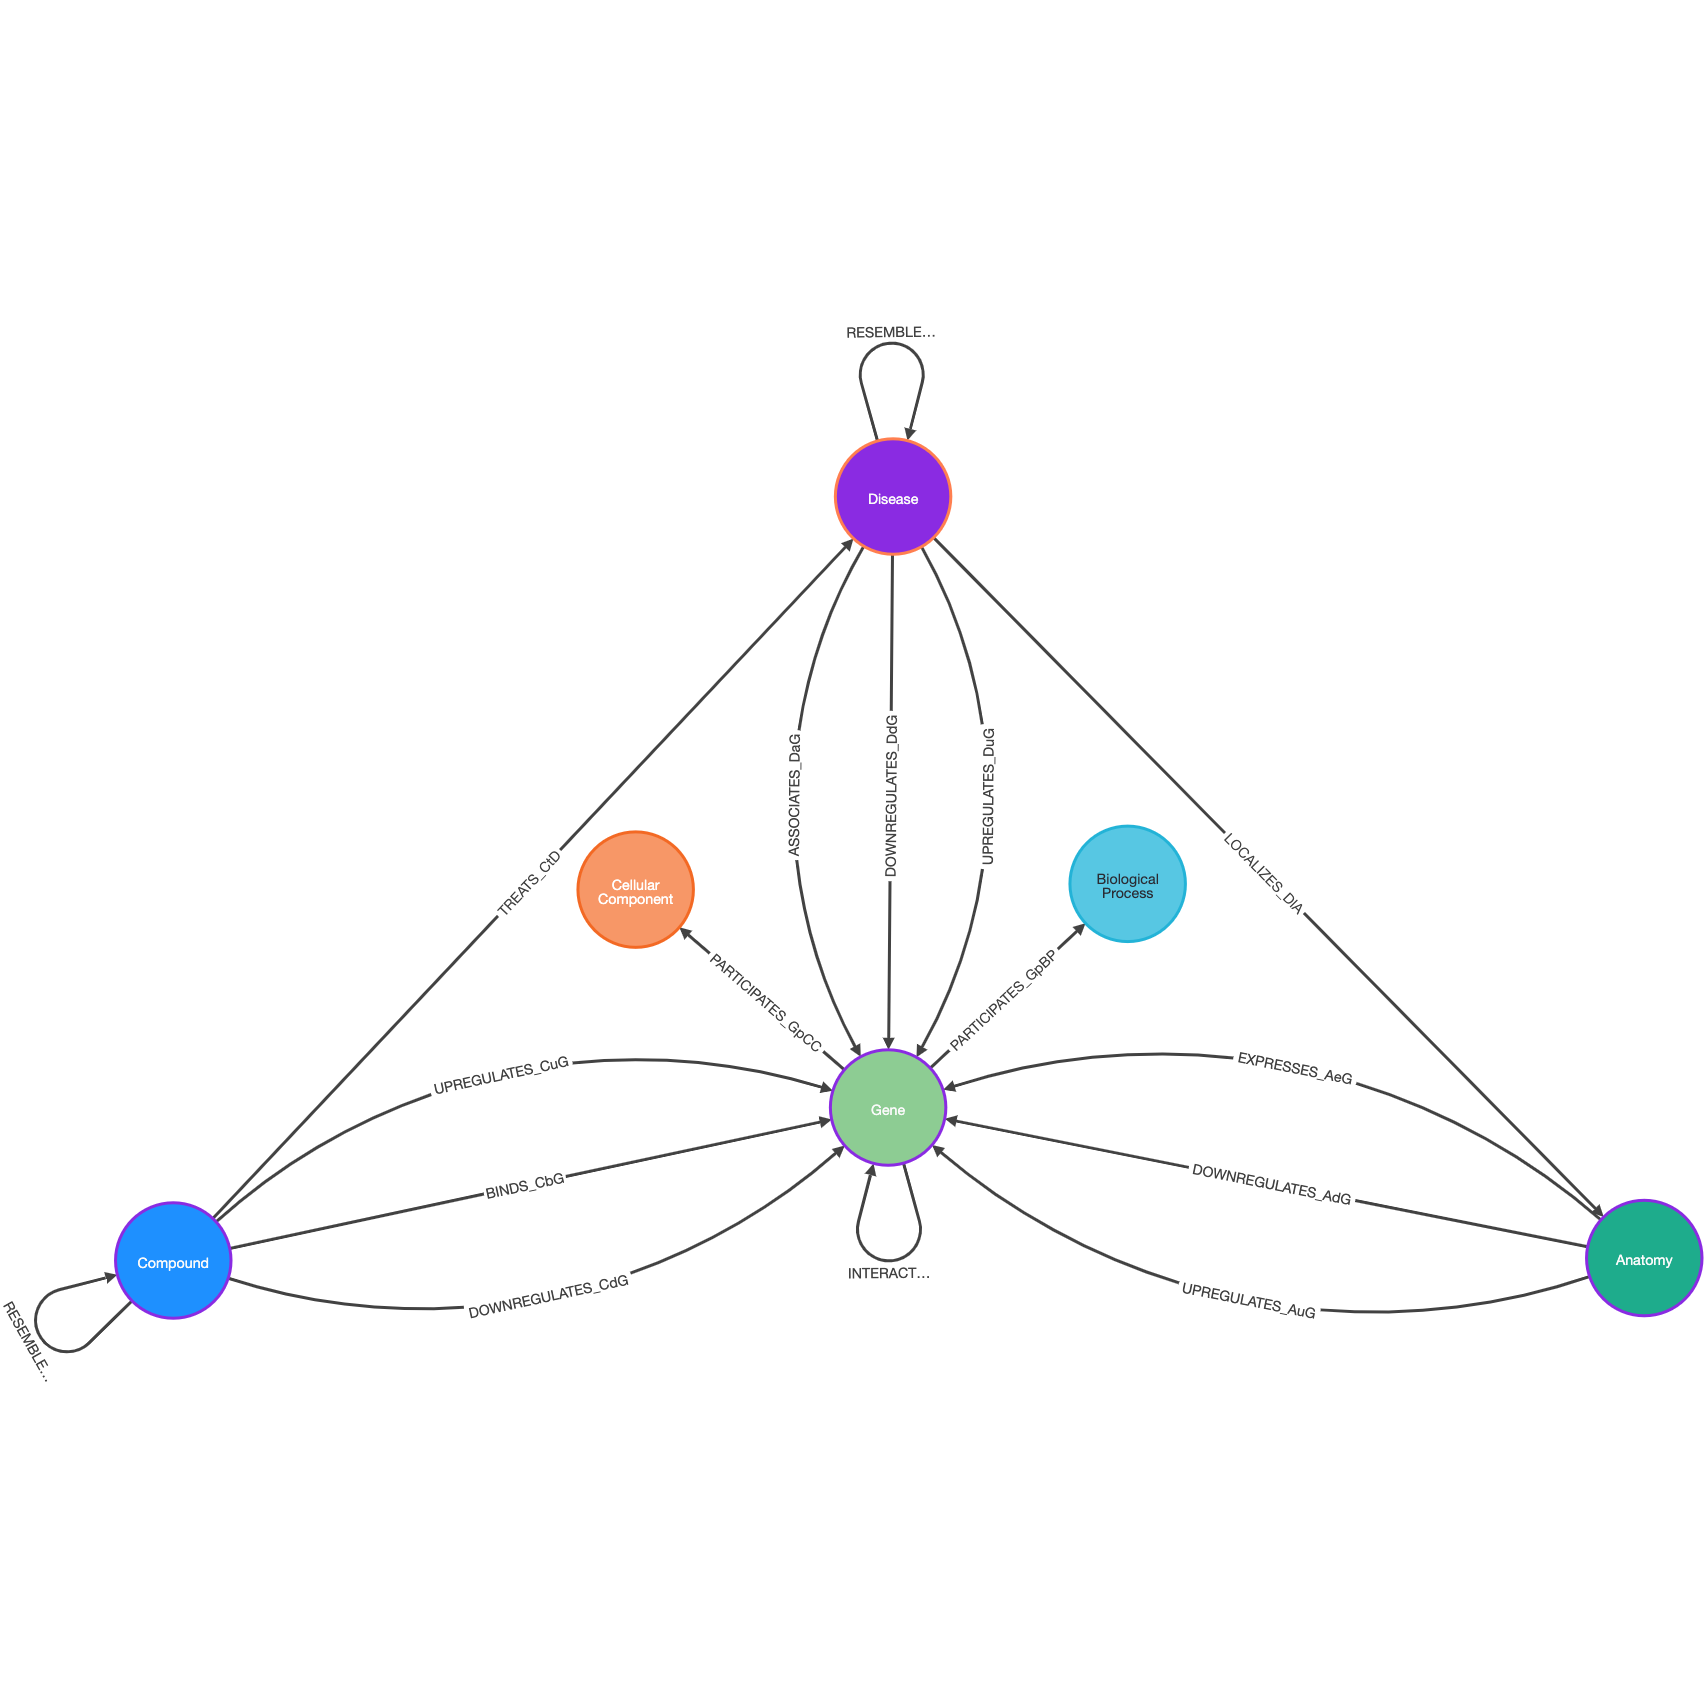

In [6]:
# Graph Database Schema
from neographviz import vis

vis.Image(data="schema.png", format="png", retina=False, embed=True, unconfined=False)

__Create Unique Property Constraints__

- Remove orphan nodes prior to applying constraints

In [59]:
# Create Unique Property Constraints

queries = {
    "q1": "CREATE CONSTRAINT ON (x:Anatomy) ASSERT x.Id IS UNIQUE",
    "q2": "CREATE CONSTRAINT ON (x:Compound) ASSERT x.Id IS UNIQUE",
    "q3": "CREATE CONSTRAINT ON (x:Gene) ASSERT x.Id IS UNIQUE;",
    "q4": "CREATE CONSTRAINT ON (x:Disease) ASSERT x.Id IS UNIQUE;",
    "q5": "CREATE CONSTRAINT ON (x:`Cellular Component`) ASSERT x.Id IS UNIQUE;",
    "q6": "CREATE CONSTRAINT ON (x:`Biological Process`) ASSERT x.Id IS UNIQUE;",
    "q7": "CREATE CONSTRAINT ON (x:Anatomy) ASSERT x.name IS UNIQUE;",
    "q8": "CREATE CONSTRAINT ON (x:Compound) ASSERT x.name IS UNIQUE;",
    "q9": "CREATE CONSTRAINT ON (x:Gene) ASSERT x.name IS UNIQUE;",
    "q10": "CREATE CONSTRAINT ON (x:Disease) ASSERT x.cui IS UNIQUE;",
    "q11": "CREATE CONSTRAINT ON (x:`Cellular Component`) ASSERT x.name IS UNIQUE;",
    "q12": "CREATE CONSTRAINT ON (x:`Biological Process`) ASSERT x.name IS UNIQUE;",
}

for q in queries.values():
    gds.run_cypher(q)

In [60]:
# Node labels & Counts (frequency)

gds.run_cypher(
    """
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as frequency', {})
YIELD value 
RETURN label, value.frequency AS frequency;
"""
).head(6).sort_values(by=["frequency"], ascending=False)

,label,frequency
0,Gene,18959
3,Biological Process,10910
1,Compound,1449
4,Cellular Component,1355
5,Anatomy,363
2,Disease,122


In [61]:
# Relationship Types & Counts (frequency)

gds.run_cypher(
    """
CALL db.relationshipTypes() 
YIELD relationshipType as type
CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() 
RETURN count(*) as frequency', {})
YIELD value
RETURN type AS relationshipType, value.frequency AS frequency
"""
).sort_values(by=["frequency"], ascending=False)

,relationshipType,frequency
0,PARTICIPATES_GpBP,538940
2,EXPRESSES_AeG,505724
12,INTERACTS_GiG,147132
10,DOWNREGULATES_AdG,94200
9,UPREGULATES_AuG,91744
1,PARTICIPATES_GpCC,70672
14,DOWNREGULATES_CdG,41450
13,UPREGULATES_CuG,18420
3,ASSOCIATES_DaG,11886
11,BINDS_CbG,11334


In [56]:
# Define a few helper functions for projecting an in memory graph, dropping it & calculating pageRank


def create_in_memory_graph(gName: str):
    query = (
        f"CALL gds.graph.project('{gName}', '*', '*') " \
        "YIELD graphName, nodeCount, relationshipCount".format(gName=gName)
    )
    return gds.run_cypher(query)


def drop_in_memory_graph(gName: str):
    query = f"CALL gds.graph.drop('{gName}') YIELD graphName;"
    return gds.run_cypher(query)


def calc_pagerank(gName: str, maxIterations: int, dampingFactor: float):
    query = (
        f"CALL gds.pageRank.write('{gName}', " \
        f"{{ maxIterations: {maxIterations}, " \
        f"dampingFactor: {dampingFactor}, " \
        f"writeProperty: 'pageRank'}}) " \
        f"YIELD nodePropertiesWritten, ranIterations";
    )

    return gds.run_cypher(query)

In [25]:
create_in_memory_graph(gName="graph")

,graphName,nodeCount,relationshipCount
0,graph,33158,1556135


In [57]:
pageRank = calc_pagerank(gName="graph", maxIterations=20, dampingFactor=0.85)
pageRank

,nodePropertiesWritten,ranIterations
0,33158,16


In [58]:
drop_in_memory_graph(gName="graph")

,graphName
0,graph
